In [116]:
import pandas as pd


# 1981-2005

In [117]:
def diff_yields(df):
    for col in df.columns:
        if col.startswith('DGS'):
            df[f'{col}_diff'] = df[col].diff()
    # Now `df` is a DataFrame containing your CSV data

    df.fillna(method = 'bfill', inplace = True)
    return df

In [ ]:
#1981-2005 
look_ahead = 12 

yields = pd.read_csv('U.S Treasury Bonds 1981 - 2005.csv', parse_dates=['observation_date'])
yields = diff_yields(yields)
recession = pd.read_csv('USREC 1981 - 2005.csv', parse_dates=['observation_date'])
unemployment = pd.read_csv('UNRATE 1981 - 2005.csv', parse_dates=['observation_date'])
industrial_prod = pd.read_csv('INDPRO 1981-2005.csv', parse_dates=['observation_date'])

df = yields.merge(recession, on='observation_date')\
           .merge(unemployment, on='observation_date')\
           .merge(industrial_prod, on='observation_date')

# Feature Engineering
df['10y_minus_3m'] = df['DGS10'] - df['DGS3MO']
df['10y_minus_2y'] = df['DGS10'] - df['DGS2']

# Shift the recession indicator by 12 months forward
df['recession_next_year'] = df['USREC'].shift(-1*look_ahead)

# Drop rows with NaNs created by shifting
df = df.dropna()

# Features (X) and Target (y)
# feature_cols = ['10y_minus_3m', '10y_minus_2y', 'UNRATE', 'INDPRO']
# X = df[feature_cols]
# y = df['recession_next_year']

y = df['recession_next_year']
X = df.drop(columns=['observation_date', 'recession_next_year'])
dates_8505 = df['observation_date']
print(X.head())
print(y.head())

   DGS3MO  DGS6MO   DGS1   DGS2   DGS3   DGS5   DGS7  DGS10  DGS20  DGS30  \
0   15.61   16.36  16.52  16.46  16.22  15.93  15.65  15.32  15.07  14.67   
1   14.23   15.06  15.38  15.54  15.50  15.41  15.33  15.15  15.13  14.68   
2   11.35   12.12  12.41  12.88  13.11  13.38  13.42  13.39  13.56  13.35   
3   11.32   12.44  12.85  13.29  13.66  13.60  13.62  13.72  13.73  13.45   
4   12.92   13.90  14.32  14.57  14.64  14.65  14.67  14.59  14.57  14.22   

   ...  DGS5_diff  DGS7_diff  DGS10_diff  DGS20_diff  DGS30_diff  USREC  \
0  ...      -0.52      -0.32       -0.17        0.06        0.01      1   
1  ...      -0.52      -0.32       -0.17        0.06        0.01      1   
2  ...      -2.03      -1.91       -1.76       -1.57       -1.33      1   
3  ...       0.22       0.20        0.33        0.17        0.10      1   
4  ...       1.05       1.05        0.87        0.84        0.77      1   

   UNRATE   INDPRO  10y_minus_3m  10y_minus_2y  
0     7.6  51.3429         -0.29     

C:\Users\delen\AppData\Local\Temp\ipykernel_1300\2456478515.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = 'bfill', inplace = True)


In [119]:
df.columns

Index(['observation_date', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5',
       'DGS7', 'DGS10', 'DGS20', 'DGS30', 'DGS3MO_diff', 'DGS6MO_diff',
       'DGS1_diff', 'DGS2_diff', 'DGS3_diff', 'DGS5_diff', 'DGS7_diff',
       'DGS10_diff', 'DGS20_diff', 'DGS30_diff', 'USREC', 'UNRATE', 'INDPRO',
       '10y_minus_3m', '10y_minus_2y', 'recession_next_year'],
      dtype='object')

In [120]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# 1. Scaling the features (good practice for regression models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train the model_8505 (using all available data)
model_8505 = LogisticRegressionCV()
model_8505.fit(X_scaled, y)

# 3. Make predictions
threshold = 0.1
y_pred_proba = model_8505.predict_proba(X_scaled)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)
# 4. Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))

# 5. (Optional) Predict recession probabilities
recession_prob = model_8505.predict_proba(X_scaled)[:, 1]

# 6. Create a DataFrame to see results
prediction_df = df.copy()
prediction_df['Predicted_Recession'] = y_pred[:len(prediction_df)]
prediction_df['Probability_Recession'] = recession_prob[:len(prediction_df)]

print("\nFirst few predictions:\n")
print(prediction_df[['Predicted_Recession', 'Probability_Recession']].head())

Confusion Matrix:
 [[208  42]
 [  0  19]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.83      0.91       250
         1.0       0.31      1.00      0.47        19

    accuracy                           0.84       269
   macro avg       0.66      0.92      0.69       269
weighted avg       0.95      0.84      0.88       269


First few predictions:

   Predicted_Recession  Probability_Recession
0                    1               0.796622
1                    1               0.516995
2                    1               0.345836
3                    0               0.040336
4                    0               0.038464


c:\Users\delen\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<function matplotlib.pyplot.show(close=None, block=None)>

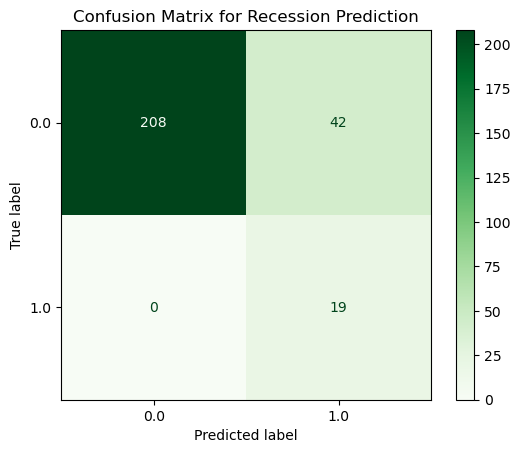

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_8505.classes_)
disp.plot(cmap='Greens')
plt.title('Confusion Matrix for Recession Prediction')
plt.savefig('confusion_matrix_1985.png')
plt.show

Corporate Bond Risk Premium

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [123]:
baa = pd.read_csv('DBAA.csv', parse_dates=['observation_date'])
aaa = pd.read_csv('DAAA.csv', parse_dates=['observation_date'])


baa = baa.rename(columns={'DBAA': 'yield_baa'})
aaa = aaa.rename(columns={'DAAA': 'yield_aaa'})


df = pd.merge(baa, aaa, on='observation_date', how='inner')


df['risk_premium'] = df['yield_baa'] - df['yield_aaa']


df['year'] = df['observation_date'].dt.year
annual_prem = df.groupby('year')['risk_premium'].mean().reset_index()

print(df.head())        # monthly spread
print(annual_prem)      # yearly average spread


  observation_date  yield_baa  yield_aaa  risk_premium  year
0       2005-01-01       6.02       5.36          0.66  2005
1       2005-02-01       5.82       5.20          0.62  2005
2       2005-03-01       6.06       5.40          0.66  2005
3       2005-04-01       6.05       5.33          0.72  2005
4       2005-05-01       6.01       5.15          0.86  2005
    year  risk_premium
0   2005      0.829167
1   2006      0.891667
2   2007      0.926667
3   2008      1.815000
4   2009      1.982500
5   2010      1.095000
6   2011      1.025000
7   2012      1.261667
8   2013      0.866667
9   2014      0.691667
10  2015      1.112500
11  2016      1.051667
12  2017      0.696667
13  2018      0.870000
14  2019      0.988333
15  2020      1.125833
16  2021      0.690000
17  2022      0.998333
18  2023      1.050833
19  2024      0.709167
20  2025      0.620000


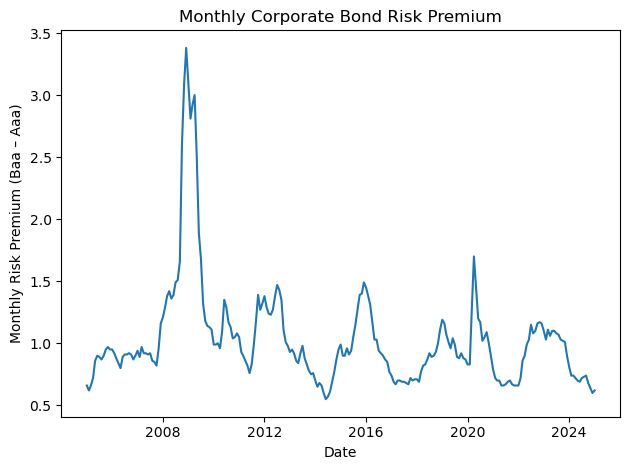

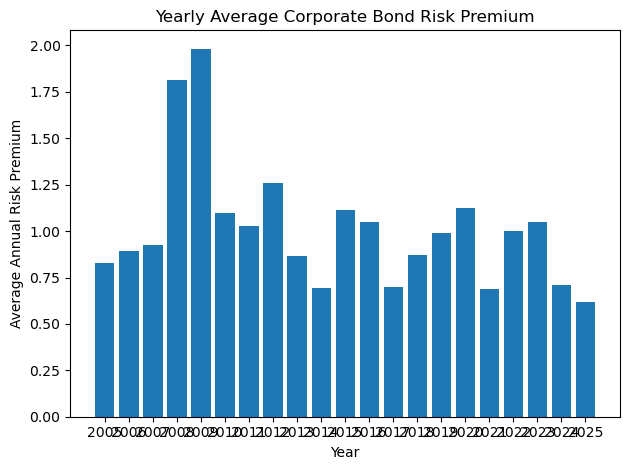

In [124]:
fig, ax = plt.subplots()
ax.plot(df['observation_date'], df['risk_premium'])
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Risk Premium (Baa – Aaa)')
ax.set_title('Monthly Corporate Bond Risk Premium')
plt.tight_layout()

# 2) Annual Average Risk Premium
fig, ax = plt.subplots()
ax.bar(annual_prem['year'].astype(str), annual_prem['risk_premium'])
ax.set_xlabel('Year')
ax.set_ylabel('Average Annual Risk Premium')
ax.set_title('Yearly Average Corporate Bond Risk Premium')
plt.tight_layout()

plt.show()


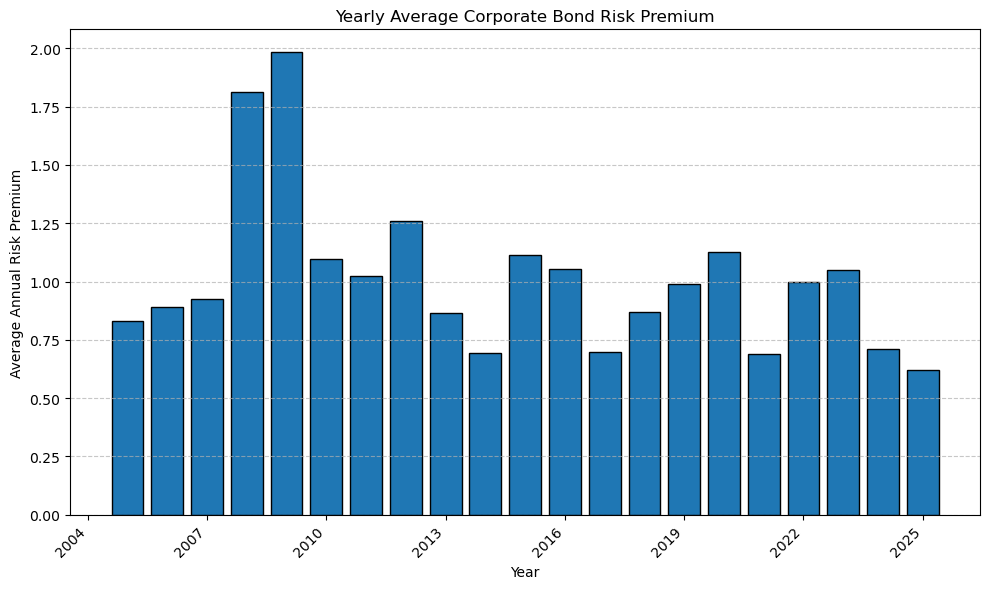

In [125]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

years = annual_prem['year']
premiums = annual_prem['risk_premium']

fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart
ax.bar(years, premiums, edgecolor='black')

# Labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Average Annual Risk Premium')
ax.set_title('Yearly Average Corporate Bond Risk Premium')

# Force integer ticks and reduce the number of ticks
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

# Rotate tick labels for clarity
plt.xticks(rotation=45, ha='right')

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# 2005-2025

In [126]:
import pandas as pd

# Load all your datasets
yields = pd.read_csv('USTBONDS 2005 - 2025.csv', parse_dates=['observation_date'])
yields = diff_yields(yields)
recession = pd.read_csv('USREC.csv', parse_dates=['observation_date'])
unemployment = pd.read_csv('UNRATE.csv', parse_dates=['observation_date'])
industrial_prod = pd.read_csv('INDPRO.csv', parse_dates=['observation_date'])

# Merge everything by observation_date
df = yields.merge(recession, on='observation_date')\
           .merge(unemployment, on='observation_date')\
           .merge(industrial_prod, on='observation_date')

# Feature Engineering
df['10y_minus_3m'] = df['DGS10'] - df['DGS3MO']
df['10y_minus_2y'] = df['DGS10'] - df['DGS2']

# Shift the recession indicator by 12 months forward
df['recession_next_year'] = df['USREC'].shift(-1*look_ahead)

# Drop rows with NaNs created by shifting
df = df.dropna()

# Features (X) and Target (y)
#feature_cols = ['10y_minus_3m', '10y_minus_2y', 'UNRATE', 'INDPRO']
#X = df[feature_cols]
y_25 = df['recession_next_year']
X_25 = df.drop(columns=['observation_date', 'recession_next_year'])
dates_0525 = df['observation_date']
print(X_25.head())
print(y_25.head())

   DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  DGS20  DGS30  ...  \
0    2.37    2.68  2.86  3.22  3.39  3.71  3.97   4.22   4.77   4.77  ...   
1    2.58    2.85  3.03  3.38  3.54  3.77  3.97   4.17   4.61   4.56  ...   
2    2.80    3.09  3.30  3.73  3.91  4.17  4.33   4.50   4.89   4.77  ...   
3    2.84    3.14  3.32  3.65  3.79  4.00  4.16   4.34   4.75   4.65  ...   
4    2.90    3.17  3.33  3.64  3.72  3.85  3.94   4.14   4.56   4.49  ...   

   DGS5_diff  DGS7_diff  DGS10_diff  DGS20_diff  DGS30_diff  USREC  UNRATE  \
0       0.06       0.00       -0.05       -0.16       -0.21      0     5.3   
1       0.06       0.00       -0.05       -0.16       -0.21      0     5.4   
2       0.40       0.36        0.33        0.28        0.21      0     5.2   
3      -0.17      -0.17       -0.16       -0.14       -0.12      0     5.2   
4      -0.15      -0.22       -0.20       -0.19       -0.16      0     5.1   

    INDPRO  10y_minus_3m  10y_minus_2y  
0  95.8785          1.85   

C:\Users\delen\AppData\Local\Temp\ipykernel_1300\2456478515.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = 'bfill', inplace = True)


In [127]:
X_25_scaled = scaler.transform(X_25)
y_25_pred = model_8505.predict(X_25_scaled)
y_25_pred_proba = model_8505.predict_proba(X_25_scaled)[:,1]
y_25_pred = (y_25_pred_proba >= threshold).astype(int)

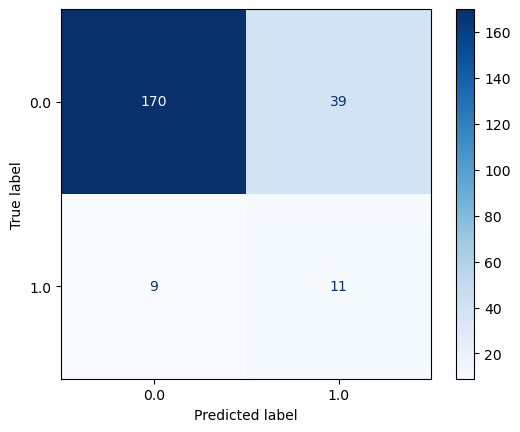

In [128]:
cfm = confusion_matrix(y_25, y_25_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=model_8505.classes_)
disp.plot(cmap='Blues')

In [129]:
y_25_pred_proba

array([0.01871973, 0.02439241, 0.02887509, 0.03634458, 0.04448773,
       0.05326513, 0.05649147, 0.06861291, 0.08167826, 0.07178127,
       0.08848558, 0.10367   , 0.11816131, 0.12862214, 0.14962548,
       0.1404354 , 0.13326709, 0.13689503, 0.1565177 , 0.18648625,
       0.19423469, 0.19004157, 0.20243924, 0.2227342 , 0.19360687,
       0.21251127, 0.22455751, 0.20173362, 0.18998388, 0.15169983,
       0.1382846 , 0.16642679, 0.11281901, 0.08755794, 0.0964943 ,
       0.05707678, 0.04240722, 0.02985171, 0.0149169 , 0.00833025,
       0.00887932, 0.00992122, 0.01187672, 0.01018892, 0.00947083,
       0.00525916, 0.00339178, 0.00376689, 0.00405732, 0.00294961,
       0.00267102, 0.00228885, 0.00163852, 0.0010257 , 0.00130888,
       0.00127125, 0.00136354, 0.0013385 , 0.00130564, 0.00106245,
       0.00097312, 0.00096528, 0.00094138, 0.00092866, 0.00122631,
       0.00159555, 0.00181413, 0.00223295, 0.00242952, 0.00278999,
       0.00222312, 0.00153072, 0.00142083, 0.00125543, 0.00135

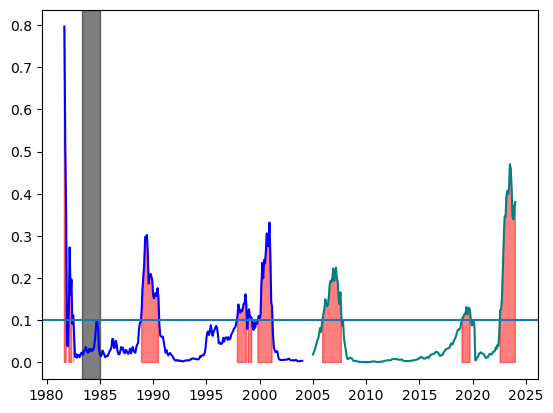

In [130]:
#probability of recessions 1985-2005
threshold = 0.1
plt.plot(dates_8505, y_pred_proba, label='Predicted Probability of Recession', color='blue')
plt.plot(dates_0525, y_25_pred_proba, label='Predicted Probability of Recession (2005-25)', color='teal')
plt.axhline(threshold)
plt.fill_between(dates_8505, 0, y_pred_proba, where=(y_pred_proba > threshold), color='red', alpha=0.5, label='Predicted Recession')
plt.axvspan(dates_8505[20], dates_8505[40], color='black', alpha=0.5, label='Recession Period')
plt.fill_between(dates_0525, 0, y_25_pred_proba, where=(y_25_pred_proba > threshold), color='red', alpha=0.5, label='Predicted Recession')
plt.show()

Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96        53
         1.0       0.00      0.00      0.00         1

    accuracy                           0.93        54
   macro avg       0.49      0.47      0.48        54
weighted avg       0.96      0.93      0.94        54



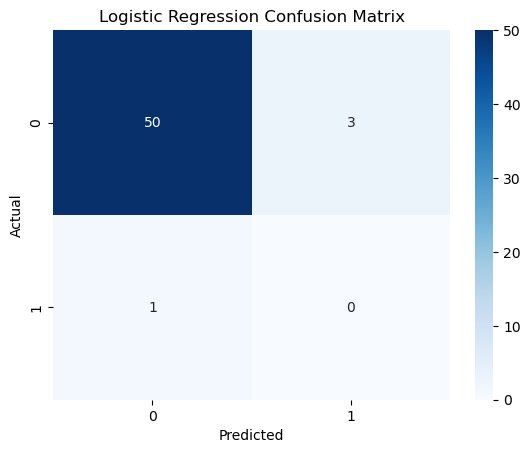

Model: Decision Tree
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        53
         1.0       0.50      1.00      0.67         1

    accuracy                           0.98        54
   macro avg       0.75      0.99      0.83        54
weighted avg       0.99      0.98      0.98        54



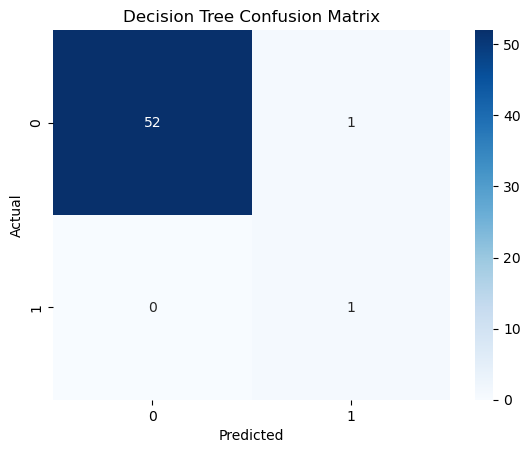

Model: Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        53
         1.0       0.50      1.00      0.67         1

    accuracy                           0.98        54
   macro avg       0.75      0.99      0.83        54
weighted avg       0.99      0.98      0.98        54



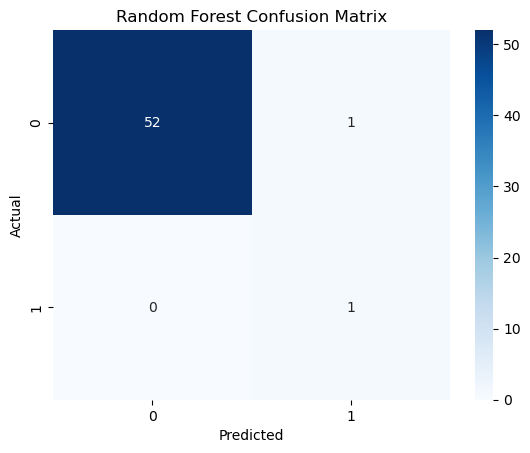

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Print Evaluation
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [132]:
models

{'Logistic Regression': LogisticRegression(max_iter=1000),
 'Decision Tree': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier()}

In [133]:
models['Decision Tree'].feature_importances_
feature_names = models['Decision Tree'].feature_names_in_


{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'monotonic_cst': None,
 'feature_names_in_': array(['DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7',
        'DGS10', 'DGS20', 'DGS30', 'DGS3MO_diff', 'DGS6MO_diff',
        'DGS1_diff', 'DGS2_diff', 'DGS3_diff', 'DGS5_diff', 'DGS7_diff',
        'DGS10_diff', 'DGS20_diff', 'DGS30_diff', 'USREC', 'UNRATE',
        'INDPRO', '10y_minus_3m', '10y_minus_2y'], dtype=object),
 'n_features_in_': 25,
 'n_outputs_': 1,
 'classes_': array([0., 1.]),
 'n_classes_': 2,
 'max_features_': 25,
 'tree_': <sklearn.tree._tree.Tree at 0x1c79fbe6a30>}

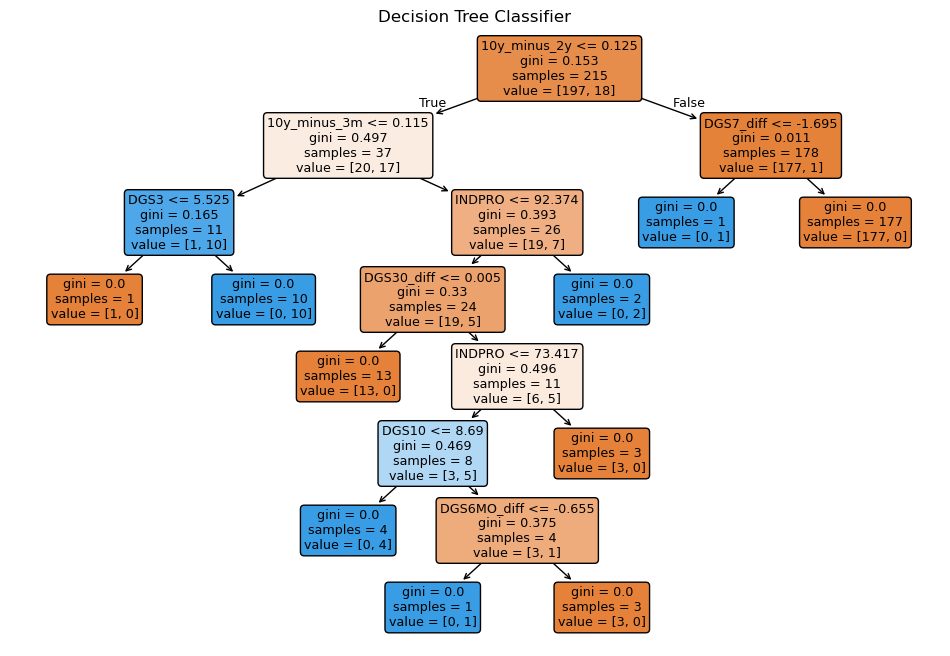

In [134]:

from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(models['Decision Tree'], feature_names=feature_names, filled=True, rounded=True)
plt.title('Decision Tree Classifier') 
models['Decision Tree'].__dict__

In [135]:
models['Random Forest'].feature_importances_

array([0.03672492, 0.04074244, 0.04062501, 0.04133501, 0.02925068,
       0.03240525, 0.03653351, 0.03481386, 0.01680664, 0.02151862,
       0.02035086, 0.03289299, 0.01499502, 0.02848951, 0.01268634,
       0.01356044, 0.01208081, 0.01542051, 0.01317951, 0.01116857,
       0.        , 0.05055821, 0.07183188, 0.20801228, 0.16401714])

In [136]:
models['Logistic Regression'].coef_

array([[ 0.62174648,  0.61725823,  0.0017879 ,  0.26051505,  0.25198621,
         0.10911297, -0.02750576, -0.40399407,  0.02658747, -0.92580235,
        -0.85429421, -0.63365173, -0.23389482, -0.01955961,  0.07005498,
         0.1645766 ,  0.14391244,  0.14307837, -0.45547927,  0.22037762,
        -0.08151818, -1.18612281, -0.03899017, -1.02574055, -0.66450912]])

In [137]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0.])

In [138]:
X_train

,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30,...,DGS5_diff,DGS7_diff,DGS10_diff,DGS20_diff,DGS30_diff,USREC,UNRATE,INDPRO,10y_minus_3m,10y_minus_2y
115,5.83,5.98,6.24,6.95,7.23,7.70,7.92,8.04,6.07,8.21,...,-0.07,-0.08,-0.07,0.31,-0.08,0,6.7,60.4524,2.21,1.09
33,10.26,11.24,12.08,12.91,13.18,13.48,13.56,13.56,13.54,13.44,...,0.31,0.22,0.15,0.11,0.01,0,7.2,54.3075,3.30,0.65
180,5.24,5.45,5.83,6.23,6.41,6.60,6.73,6.83,7.17,7.03,...,0.21,0.21,0.19,0.20,0.19,0,5.2,76.2302,1.59,0.60
141,3.14,3.29,3.54,4.16,4.53,5.22,5.61,5.96,6.07,6.81,...,0.02,-0.05,-0.08,0.31,-0.11,0,7.0,64.9476,2.82,1.80
248,1.76,1.91,2.35,3.26,3.80,4.49,4.90,5.16,5.81,5.76,...,-0.16,-0.12,-0.05,-0.04,-0.03,0,5.8,89.9348,3.40,1.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,8.50,8.70,8.90,9.49,9.66,10.03,10.30,10.38,10.67,10.53,...,0.01,0.01,-0.02,0.04,0.05,0,10.1,48.7470,1.88,0.89
188,5.20,5.53,5.87,6.28,6.42,6.57,6.66,6.71,7.02,6.94,...,-0.19,-0.20,-0.18,-0.18,-0.15,0,4.9,79.4296,1.51,0.43
71,6.23,6.46,7.03,7.75,8.03,8.32,8.59,8.76,6.07,8.97,...,0.31,0.32,0.31,0.31,0.33,0,6.0,58.6784,2.53,1.01
106,7.87,7.92,7.94,8.16,8.26,8.33,8.46,8.47,6.07,8.50,...,-0.10,-0.06,-0.01,0.31,0.04,0,5.5,62.6435,0.60,0.31


In [139]:
X

,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30,...,DGS5_diff,DGS7_diff,DGS10_diff,DGS20_diff,DGS30_diff,USREC,UNRATE,INDPRO,10y_minus_3m,10y_minus_2y
0,15.61,16.36,16.52,16.46,16.22,15.93,15.65,15.32,15.07,14.67,...,-0.52,-0.32,-0.17,0.06,0.01,1,7.6,51.3429,-0.29,-1.14
1,14.23,15.06,15.38,15.54,15.50,15.41,15.33,15.15,15.13,14.68,...,-0.52,-0.32,-0.17,0.06,0.01,1,7.9,50.9463,0.92,-0.39
2,11.35,12.12,12.41,12.88,13.11,13.38,13.42,13.39,13.56,13.35,...,-2.03,-1.91,-1.76,-1.57,-1.33,1,8.3,50.3546,2.04,0.51
3,11.32,12.44,12.85,13.29,13.66,13.60,13.62,13.72,13.73,13.45,...,0.22,0.20,0.33,0.17,0.10,1,8.5,49.8086,2.40,0.43
4,12.92,13.90,14.32,14.57,14.64,14.65,14.67,14.59,14.57,14.22,...,1.05,1.05,0.87,0.84,0.77,1,8.6,48.7877,1.67,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.96,1.03,1.24,1.71,2.23,3.18,3.74,4.27,5.21,5.28,...,-0.19,-0.22,-0.18,-0.18,-0.17,0,6.1,91.3819,3.31,2.56
265,0.94,1.02,1.25,1.75,2.26,3.19,3.75,4.29,5.21,5.30,...,0.01,0.01,0.02,0.00,0.02,0,6.0,91.5049,3.35,2.54
266,0.95,1.04,1.34,1.93,2.45,3.29,3.81,4.30,5.17,5.25,...,0.10,0.06,0.01,-0.04,-0.05,0,5.8,92.1265,3.35,2.37
267,0.91,1.01,1.31,1.91,2.44,3.27,3.79,4.27,5.11,5.21,...,-0.02,-0.02,-0.03,-0.06,-0.04,0,5.7,92.1732,3.36,2.36
